#  Use SARIMAX to model the time series process 

# Define global variable(train_end, predict_start, predict_end) and common functions

Define train and predict windows 

In [25]:
# for development 
# train_end='2019-6'
# predict_start='2019-7'
# predict_end='2019-9'

# for final submit 
train_end='2019-9'
predict_start='2019-10'
predict_end='2019-12'

## Auto_arima Function
 

In [ ]:
# suppress warning to make cleaner output 
import warnings
warnings.filterwarnings("ignore")

In [26]:
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [27]:
import pmdarima as pm 
def auto_arima(df,col_exog,d=0):
    try:
        results=pm.auto_arima(df[['stock_distributed']],
                              exog=df[col_exog],
                              seasonal=True,information_criterion='bic',m=12,
                          d=d, D=0, 
                          max_p=4, max_q=4, 
                          trace=False, # can turn Trace off 
                          error_action='ignore',
                          suppress_warnings=True)
        print(results.order)
        print(results.seasonal_order)
        #print(col_exog)
        return[results.order,results.seasonal_order] 
    except:
        print('error searching')

## SARIMAX - Region

It's region specific because the df_pred_agg_results_piece. The result collection part and the plot part assumes df is on regional level 

In [48]:

def predict_sarimax(df,order,seasonal_order,col_exog,plot=0):
    try:
        df_train=df[:train_end]
        df_test=df[predict_start:predict_end]
        model = SARIMAX(df_train['stock_distributed'], order=order,seasonal_order=seasonal_order,
                        exog=df_train[col_exog])
        result=model.fit()
        sarima_mean_insample=result.get_prediction(start=df_train.index[0],end=train_end,
                                                   exog=df_train[col_exog]).predicted_mean
        sarima_mean_outsample=result.get_prediction(start=predict_start,end=predict_end,
                                                    exog=df[predict_start:predict_end][col_exog]).predicted_mean
        sarima_mean_prediction=sarima_mean_insample.append(sarima_mean_outsample)
        region=df.iloc[0].region
        product_code=df.iloc[0].product_code
        
        df_pred_agg_results_piece=pd.DataFrame(data=sarima_mean_prediction,columns=['stock_distributed_forecasted'])
        df_pred_agg_results_piece['region']=region
        df_pred_agg_results_piece['product_code']=product_code 
        if plot==1:
            pd.DataFrame({'insample_pred':sarima_mean_insample,'outsample_pred':sarima_mean_outsample,'actual_value':df_train['stock_distributed']}).plot(); 
            plt.title(region+"--"+product_code)
            plt.show()
        return df_pred_agg_results_piece
    except:
        print('error')

# Import and process data 

## Import '../0_data/df_combined_fullsample.csv'

In [29]:
import pandas as pd
 #  contraceptive_logistics=pd.read_csv('../0_data/df_combined.csv') 
contraceptive_logistics=pd.read_csv('../0_data/df_combined_fullsample.csv')
contraceptive_logistics['day']=1
contraceptive_logistics['date']=pd.to_datetime(contraceptive_logistics[['year','month','day']])
contraceptive_logistics=contraceptive_logistics.sort_values('date')

## Aggregate on regional level 

In [30]:
col_continuous=['regionroads',
       'regionasphaltroads', 'regionearthroads', 'regionsurfacetreatmentroads',
       'regionpoorroads', 'poorroads', 'earthroads', 'asphaltroads',
       'site_type', 'product_type', 'temp', 'maxtemp', 'pressure',
       'relativehumidity', 'rainfallsnowmelt', 'visibility', 'windspeed',
       'maxsustainedwindspeed', 'rainordrizzle', 'storm', 'fog']
col_continuous.remove('site_type') # they are not continuous
col_continuous.remove('product_type') # they are not continuous

In [31]:
product_region_level_sum=contraceptive_logistics.groupby(['region','product_code','date'])['stock_distributed'].sum()
df_product_region_level_sum=pd.DataFrame(data=product_region_level_sum)
df_product_region_level_sum=df_product_region_level_sum.reset_index()
for col in col_continuous:
    #print(col)
    df_product_region_level_sum[col]=pd.DataFrame(data=contraceptive_logistics.groupby(['region','product_code','date'])[col].mean().values)


regionroads
regionasphaltroads
regionearthroads
regionsurfacetreatmentroads
regionpoorroads
poorroads
earthroads
asphaltroads
temp
maxtemp
pressure
relativehumidity
rainfallsnowmelt
visibility
windspeed
maxsustainedwindspeed
rainordrizzle
storm
fog


# SARIMAX

In [32]:
col_exog=col_continuous

### Testing - pick a random series

In [33]:
import random 
random_region=random.choice(df_product_region_level_sum['region'].unique())
df1=df_product_region_level_sum[df_product_region_level_sum['region']==random_region];
random_product_code=random.choice(df1['product_code'].unique())
df2=df1[df1['product_code']==random_product_code].copy()
len(df2)

46

In [34]:
df2['date']=pd.to_datetime(df2['date']);
df2=df2.set_index(['date']);
df2=df2.resample('MS').fillna('nearest')

GBEKE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=383.691, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=359.470, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=373.841, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=426.995, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=355.929, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=359.358, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=355.818, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=359.309, Time=0.13 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=359.062, Time=0.10 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=359.627, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=359.600, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] interc

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


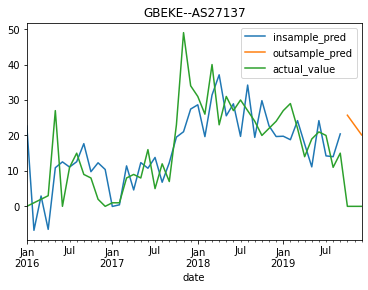

GBEKE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=355.708, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=387.033, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=354.878, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=369.323, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=418.675, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=357.244, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=352.236, Time=0.22 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=0.67 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=355.994, Time=0.12 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=378.675, Time=0.19 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : BIC=350.475, Time=0.34 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=352.345, Time=0.09 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : BIC=353.754, Time=0.56 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=353.118, Time=0.25 sec
 ARIMA(3,0,0)(2,0,0)[12

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


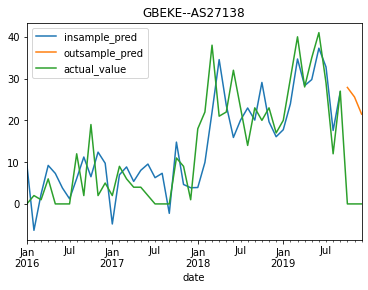

GBOKLE-NAWA-SAN PEDRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=499.528, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=485.442, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=490.417, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=561.373, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=486.210, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=487.916, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=482.561, Time=0.18 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=503.125, Time=0.07 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=486.191, Time=0.22 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=486.209, Time=0.21 sec
 ARIMA(2,0,1)(0,0,1

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


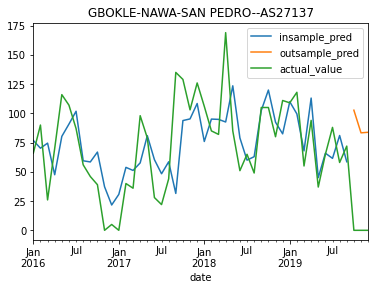

GBOKLE-NAWA-SAN PEDRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=540.134, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=542.032, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=542.676, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=560.670, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=543.686, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=543.627, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=538.804, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=541.985, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=542.376, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=542.250, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=539.612, Time=0.04 sec
 ARIMA(2,0,1)(0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


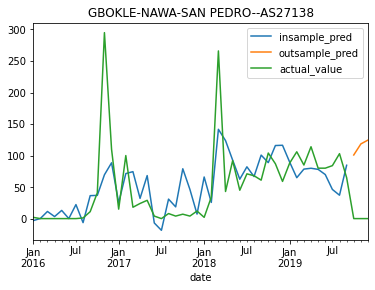

In [35]:
# testing look , plot=1 
print('\n a few examples of region level forecasts \n')
df_pred_region_product=pd.DataFrame()
for region in df_product_region_level_sum['region'].unique()[6:8] :
    df1=df_product_region_level_sum[df_product_region_level_sum['region']==region];
    for product in df1['product_code'].unique()[6:8]:
        df2=df1[df1['product_code']==product].copy();
        df2['date']=pd.to_datetime(df2['date']);
        df2=df2.set_index(['date']);
        df2=df2.resample('MS').fillna('nearest')
        print(region)
        print(product)
        #fit_and_plot_forecast(df2)
        if(len(df2)>10):
            [order,seasonal_order]=auto_arima(df2,col_exog); 
            result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=1);
            # print(result_piece)
            df_pred_region_product=pd.concat([df_pred_region_product,result_piece])

## Run the full data df_pred_region_product

### Export : df_pred_region_product.to_csv('../2_pipeline/final_pred_region_lev.csv') 

- for demo purpose, we won't run full data. One can change this line to run the full data 

In [ ]:
run_full_data=0

In [12]:
# run the full data , plot=0 
if run_full_data==1:
    print('\n make forecast on all region and products \n')
    print('\n save results as final_pred_region_lev.csv\n')
    df_pred_region_product=pd.DataFrame()
    for region in df_product_region_level_sum['region'].unique()  :
        df1=df_product_region_level_sum[df_product_region_level_sum['region']==region];
        for product in df1['product_code'].unique() :
            df2=df1[df1['product_code']==product].copy();
            df2['date']=pd.to_datetime(df2['date']);
            df2=df2.set_index(['date']);
            df2=df2.resample('MS').fillna('nearest')
            print(region)
            print(product)
            #fit_and_plot_forecast(df2)
            if(len(df2)>10):
                [order,seasonal_order]=auto_arima(df2,col_exog); 
                result_piece= predict_sarimax(df2,order,seasonal_order,col_exog,plot=0);
                # print(result_piece)
                df_pred_region_product=pd.concat([df_pred_region_product,result_piece])
    df_pred_region_product.to_csv('../2_pipeline/final_pred_region_lev.csv')

ABIDJAN 1-GRANDS PONTS
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=209.771, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=193.172, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=196.221, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=194.908, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=192.488, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=196.770, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=196.752, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=192.483, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=196.210, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=194.837, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=195.083, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=191.221, Time=0.02 sec
 ARIMA(0,0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 1-GRANDS PONTS
AS21126
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=128.636, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=129.536, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=127.703, Time=0.29 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=127

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 1-GRANDS PONTS
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=699.069, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=705.166, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=690.057, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=699.068, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=799.067, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=686.679, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=690.145, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=690.387, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=690.647, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=695.308, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=693.227, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=689.416, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.335 se

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 1-GRANDS PONTS
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=561.524, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=557.887, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=550.881, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=553.793, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=630.875, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=555.647, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=551.201, Time=0.30 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=554.698, Time=0.17 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=555.043, Time=0.40 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=547.774, Time=0.10 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=549.565, Time=0.38 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=549.472, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=553.085, Time=0.08 sec
 ARIMA

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 1-GRANDS PONTS
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=706.158, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=688.087, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=695.664, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=757.964, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=685.598, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=688.565, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=687.875, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=688.119, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=694.674, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=691.833, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=687.753, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.522 second

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 1-GRANDS PONTS
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=677.005, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=650.138, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=666.239, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=744.625, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=646.271, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=650.140, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=654.007, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=647.765, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=648.629, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=662.367, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=651.126, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=647.802, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.252 se

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 1-GRANDS PONTS
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=535.317, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=553.599, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=524.286, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=542.730, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=605.545, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=520.416, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=524.286, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=521.004, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=521.335, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=538.860, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=524.715, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=520.494, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.405 se

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 1-GRANDS PONTS
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=555.918, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=587.376, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=548.356, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=573.990, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=620.713, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=546.551, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=548.730, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=552.189, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=547.798, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=549.026, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=570.218, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=549.617, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=545.764, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : BIC=546.163, Time=0.08 sec
 A

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 1-GRANDS PONTS
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=362.241, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=347.328, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=353.502, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=353.355, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=355.081, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=349.738, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=349.593, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=353.294, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=351.099, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=351.095, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=354.974, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.318 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABIDJAN 1-GRANDS PONTS
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12]

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 1-GRANDS PONTS
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=569.647, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=576.586, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=576.643, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=583.053, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=573.448, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=573.456, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=577.327, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=572.717, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=572.772, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=576.419, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.350 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABIDJAN 2
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BI

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 2
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=727.728, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=717.244, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=716.770, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=719.484, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=788.724, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=712.898, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=716.746, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=720.583, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=716.201, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=717.067, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=715.614, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=718.497, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=721.638, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.032 seconds
(1,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 2
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=526.156, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=533.500, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=533.265, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=603.942, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=530.022, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=529.950, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=533.821, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=529.659, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=529.399, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.294 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABIDJAN 2
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=722.955, Time=0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 2
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=658.509, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=643.421, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=650.781, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=740.283, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=639.627, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=643.399, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=647.222, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=642.900, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=642.647, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=646.943, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=645.900, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=642.534, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.424 seconds
(1, 0, 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 2
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=525.073, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=531.315, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=587.241, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=528.772, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=526.431, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=527.982, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=528.145, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=529.862, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.568 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABIDJAN 2
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.53 sec


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ABIDJAN 2
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=319.294, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=325.360, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=325.546, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=321.136, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=322.218, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=322.082, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=325.722, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=322.071, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=322.483, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=321.974, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.081 seconds
(0, 0, 0)
(0, 0, 0, 12)
ABIDJAN 2
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AGNEBY-TIASSA-ME
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=623.054, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=610.694, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=609.357, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=610.710, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=664.150, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=609.753, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=612.822, Time=0.53 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=612.520, Time=0.28 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=610.087, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=616.824, Time=0.38 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=607.881, Time=0.11 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=611.577, Time=0.36 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=611.348, Time=0.24 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=608.707, Time=0.06 sec
 ARIMA(0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AGNEBY-TIASSA-ME
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=467.154, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=490.845, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=460.589, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=480.233, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=520.423, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=457.786, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=460.397, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=464.122, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=453.736, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=456.953, Time=0.21 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=457.057, Time=0.13 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=460.655, Time=0.29 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=457.430, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=456.888, Time=0.09 sec
 ARIMA(1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AGNEBY-TIASSA-ME
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=506.377, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=460.876, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=488.853, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=528.266, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=457.106, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=460.869, Time=0.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=464.725, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=456.005, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=459.688, Time=0.12 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=459.681, Time=0.11 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=463.547, Time=0.21 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=459.750, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=459.794, Time=0.07 sec
 ARIMA(1,0,1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AGNEBY-TIASSA-ME
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=242.979, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=228.063, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=233.791, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=234.530, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=231.001, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=231.930, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=231.930, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=230.171, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=230.815, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=232.799, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.047 seconds
(0, 0, 0)
(0, 0, 0, 12)
AGNEBY-TIASSA-ME
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : B

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BELIER
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=382.402, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=364.622, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=372.078, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=371.989, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=392.308, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=368.352, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=368.324, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=368.409, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=368.393, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.140 seconds
(0, 0, 0)
(0, 0, 0, 12)
BELIER
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.47 sec
 A

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BELIER
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=180.132, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=182.136, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=184.097, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=182.028, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=182.926, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=182.765, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=186.387, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=178.531, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=182.114, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=177.240, Time=0.02 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=181.047, Time=0.06 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=181.044, Time=0.06 sec
 ARIMA(2,0,0)(1,0,1)[12] i

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BELIER
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-879.788, Time=0.02 sec
Total fit time: 0.026 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
BELIER
AS46000
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1243.161, Time=0.02 sec

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '



Total fit time: 0.020 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUNKANI-GONTOUGO
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=240.436, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=220.390, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=226.895, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=227.030, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=221.184, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=223.987, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=223.959, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=223.185, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=223.359, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=225.691, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.383 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUNKANI-GONTOUGO
AS21126
BOUNKANI-GONTOUGO
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=535.297, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=537.081, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=535.565, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=564.920, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=534.163, Time=0.21 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=534.865, Time=0.44 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=532.458, Time=0.12 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=535.319, Time=0.40 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.82 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=535.815, Time=0.20 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=539.252, Time=0.27 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=inf, Time=0.04 s

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUNKANI-GONTOUGO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=404.203, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=389.751, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=393.690, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=394.456, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=411.528, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=393.470, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=393.488, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=397.285, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=389.826, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=390.588, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=393.598, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.410 seconds
(0, 0, 0)
(0, 0, 0, 12)
BOUNKANI-GONTOUGO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUNKANI-GONTOUGO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=291.942, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=294.508, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=292.272, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=308.434, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=291.466, Time=0.10 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=291.652, Time=0.23 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=289.244, Time=0.08 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.65 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=291.778, Time=0.09 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=294.394, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=297.111, Time=0.04 sec

Best model:  ARIMA(0,0

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


BOUNKANI-GONTOUGO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=424.791, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=432.364, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=432.380, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=427.610, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=428.530, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=428.543, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=432.376, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=428.637, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=428.640, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=432.500, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.376 seconds
(0, 0, 0)
(0, 0, 0, 12)
BOUNKANI-GONTOUGO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   :

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


BOUNKANI-GONTOUGO
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=167.244, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=174.278, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=174.265, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=176.978, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=170.641, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=170.628, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=170.852, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=170.852, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=174.363, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.023 seconds
(0, 0, 0)
(0, 0, 0, 12)
BOUNKANI-GONTOUGO
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CAVALLY-GUEMON
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=236.167, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=242.924, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=242.922, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=249.910, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=239.892, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=239.879, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.55 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=239.257, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=239.305, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=243.080, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.061 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CAVALLY-GUEMON
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=564.728, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=557.234, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=562.115, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=624.388, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=554.595, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=556.859, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=560.398, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=557.394, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=556.323, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=558.636, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=560.153, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=559.641, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.424 seconds
(1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CAVALLY-GUEMON
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=333.170, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=334.089, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=336.553, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=364.713, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=336.368, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=336.314, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=340.076, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=330.982, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=334.166, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=337.641, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=330.385, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=333.345, Time=0.17 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=333.528, Time=0.17 sec
 ARIMA(2,0,0)(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CAVALLY-GUEMON
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=646.192, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=623.687, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=630.772, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=630.775, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=626.933, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=627.251, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=627.250, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=631.118, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=627.110, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=627.141, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=630.956, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.520 seconds
(0, 0, 0)
(0, 0, 0, 12)
CAVALLY-GUEMON
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : B

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


CAVALLY-GUEMON
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-724.103, Time=0.02 sec
Total fit time: 0.023 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
CAVALLY-GUEMON

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



AS42018
CAVALLY-GUEMON
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=665.958, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=667.352, Time=0.25 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=667.024, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=679.505, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=669.492, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=669.419, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=673.222, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=664.015, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=667.314, Time=0.05 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=671.084, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=667.729, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=667.733, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=664.005, Time=0.06 sec
 ARIM

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBEKE
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=200.305, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=195.847, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=198.476, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=191.990, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=195.847, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=199.716, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=189.702, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=193.529, Time=0.08 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=193.528, Time=0.08 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=197.386, Time=0.31 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=191.215, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[12] interc

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBEKE
AS21126
GBEKE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=432.319, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=444.144, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=421.466, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=431.548, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=500.854, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=419.436, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=420.408, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=423.578, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=420.477, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=418.992, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=421.829, Time=0.33 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=421.345, Time=0.14 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=424.786, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=430.724, Time=0.06 sec
 ARIM

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBEKE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=341.000, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=329.317, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=329.845, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=330.595, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=351.502, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=331.592, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=329.996, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=328.053, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=329.049, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=332.762, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=330.560, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=330.070, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=329.607, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBEKE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=461.052, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=442.746, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=448.905, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=448.959, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=484.414, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=445.434, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=445.373, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=449.245, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=445.521, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=445.780, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=448.577, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.407 seconds
(0, 0, 0)
(0, 0, 0, 12)
GBEKE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.67 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBEKE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=355.708, Time=1.17 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=387.033, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=354.878, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=369.323, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=418.675, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=357.244, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=352.236, Time=0.39 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=1.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=355.994, Time=0.22 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=378.675, Time=0.32 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : BIC=350.475, Time=0.54 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=352.345, Time=0.17 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : BIC=353.754, Time=0.84 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=353.118, Time=0.25 sec
 ARIMA(3,0,0)(2,0,0)[12

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBEKE
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=243.583, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=248.568, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=249.071, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=246.546, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=246.506, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=246.554, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=250.295, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=245.154, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=245.756, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=247.538, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.472 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


GBEKE
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-983.596, Time=0.02 sec
Total fit time: 0.024 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBEKE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=523.995, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=531.618, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=531.601, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=526.833, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=527.778, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=527.761, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=527.836, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=527.838, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=531.709, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.930 seconds
(0, 0, 0)
(0, 0, 0, 12)
GBOKLE-NAWA-SAN PEDRO
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Ti

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=638.573, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=634.807, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=691.402, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=634.676, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=638.537, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=638.556, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=635.067, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=642.412, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=643.856, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.085 seconds
(1, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBOKLE-NAWA-SAN PEDRO
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=507.278, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=486.351, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=493.836, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=493.786, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=517.277, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=490.220, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=490.219, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=494.090, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=489.969, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=489.918, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=491.898, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.659 seconds
(0, 0, 0)
(0, 0, 0, 12)
GBOKLE-NAWA-SAN PEDRO
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] i

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBOKLE-NAWA-SAN PEDRO
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=537.002, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=544.470, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=544.312, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=572.711, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=540.730, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=540.548, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=540.712, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=540.718, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=544.584, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.867 seconds
(0, 0, 0)
(0, 0, 0, 12)
GBOKLE-NAWA-SAN PEDRO
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBOKLE-NAWA-SAN PEDRO
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=540.134, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=542.032, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=542.676, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=560.670, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=543.686, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=543.627, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=538.804, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=541.985, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.45 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=542.376, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=542.250, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=539.612, Time=0.05 sec
 ARIMA(2,0,1)(0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBOKLE-NAWA-SAN PEDRO
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=276.224, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=283.934, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=283.919, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=277.646, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=280.076, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=280.063, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=280.090, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=280.092, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=282.441, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.577 seconds
(0, 0, 0)
(0, 0, 0, 12)
GBOKLE-NAWA-SAN PEDRO
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GBOKLE-NAWA-SAN PEDRO
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=637.180, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=644.773, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=644.763, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=635.056, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=640.983, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=640.977, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=644.846, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=640.984, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=640.978, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=644.858, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.625 seconds
(0, 0, 0)
(0, 0, 0, 12)
GOH
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1009.550, Time=0.02 sec
Total fit time: 0.025 se

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GOH
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.02 sec
Total fit time: 0.024 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GOH
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=600.383, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=598.334, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=597.004, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=597.036, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=663.983, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=593.966, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=596.548, Time=0.33 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=600.154, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=594.001, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=586.560, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=590.370, Time=0.41 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=590.359, Time=0.31 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=596.107, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GOH
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=473.793, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=480.200, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=480.382, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=497.520, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=476.347, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=476.530, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=477.582, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=477.580, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=481.454, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.442 seconds
(0, 0, 0)
(0, 0, 0, 12)
GOH
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.09 sec
 ARIMA(0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GOH
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=552.671, Time=1.07 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=543.122, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=542.274, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=544.433, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=610.301, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=539.541, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=542.242, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=546.107, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=540.436, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=541.091, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=542.116, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=544.299, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=549.781, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 3.242 seconds
(1, 0, 0)

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GOH
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=363.998, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=381.117, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=355.675, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=367.914, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=402.251, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=352.803, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=355.561, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=359.179, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=351.800, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=355.650, Time=0.21 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=355.650, Time=0.14 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=359.500, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=355.504, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=355.582, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GOH
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=352.387, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=353.270, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=339.336, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=346.944, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=378.991, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=335.793, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=339.392, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=339.095, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=339.175, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=343.937, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=341.906, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=336.130, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.948 seconds
(1, 0, 0)
(0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GOH
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=293.658, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=289.096, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=293.609, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=299.806, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=285.608, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=289.065, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.49 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=285.587, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=289.005, Time=0.14 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=288.923, Time=0.11 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.60 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=284.652, Time=0.07 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : BIC=288.203, Time=0.19 sec
 ARIMA(3,0,0)(0,0,1)[12] intercep

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


GOH
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-853.838, Time=0.03 sec
Total fit time: 0.029 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
GOH
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=616.310, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=622.821, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=624.513, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=618.955, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=619.110, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=622.807, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=620.172, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=620.170, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=inf, Time=0.26 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.685 seconds
(0, 0, 0)
(0, 0, 0, 12)
HAMBOL
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-516.601, Time=0.02 sec
Total fit time: 0.026 seconds
(0, 0, 0)
(0

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



HAMBOL
AS21126
HAMBOL
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=472.652, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=453.029, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=460.193, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=460.027, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=516.229, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=456.900, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=456.899, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=460.771, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=456.324, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=456.161, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=459.912, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.921 seconds
(0, 0, 0)
(0, 0, 0, 12)
HAMBOL
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : B

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HAMBOL
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=552.441, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=550.760, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=543.577, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=546.742, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=607.197, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=543.704, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=547.448, Time=0.63 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=547.448, Time=0.44 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=543.670, Time=0.36 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=551.289, Time=0.67 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=549.809, Time=0.19 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=546.898, Time=0.44 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=547.176, Time=0.45 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=546.715, Time=0.26 sec
 ARIMA(2,0,1)(1,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HAMBOL
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=412.517, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=413.791, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=415.637, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=449.005, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=415.527, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=415.791, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=409.920, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=413.791, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=417.662, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=412.130, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=412.322, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=411.776, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] i

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HAMBOL
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=476.161, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=460.583, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=465.821, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=518.533, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=456.717, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=460.585, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=464.459, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=460.585, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=460.585, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=461.982, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=463.055, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=459.009, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.934 seconds
(1, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HAMBOL
AS27139
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-386.990, Time=0.02 sec
Total fit time: 0.022 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
HAMBOL
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-309.273, Time=0.02 sec
Total fit time: 0.021 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
HAMBOL
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=445.102, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=452.491, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=452.493, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=446.379, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=448.855, Time=0.08 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=448.907, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=451.712, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=448.665, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=448.642, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=452.492, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.732 seconds
(0, 0, 0)
(0, 0, 0, 12)
HAUT-SASSANDRA
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HAUT-SASSANDRA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=454.732, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=436.223, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=442.012, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=442.071, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=485.786, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=438.976, Time=0.15 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=438.814, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=442.670, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=439.190, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=439.477, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=441.007, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.928 seconds
(0, 0, 0)
(0, 0, 0, 12)
HAUT-SASSANDRA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : B

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HAUT-SASSANDRA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=483.511, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=484.704, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=473.738, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=475.332, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=502.737, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=472.499, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=472.954, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=476.737, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=476.195, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=475.934, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=473.788, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=477.315, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=474.131, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.260 second

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


HAUT-SASSANDRA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=482.140, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=479.015, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=482.478, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=534.297, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=475.319, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=478.916, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=477.437, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=477.445, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=479.176, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=481.320, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=482.791, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.969 seconds
(1, 0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


HAUT-SASSANDRA
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1009.550, Time=0.02 sec
Total fit time: 0.025 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
HAUT-SASSANDRA
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=533.307, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=533.070, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=532.570, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=547.774, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=529.316, Time=0.10 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=532.690, Time=0.14 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=532.929, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=532.904, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=529.611, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=536.768, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=536.832, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 2.201 seconds


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


INDENIE-DJUABLIN
AS17005
INDENIE-DJUABLIN
AS21126
INDENIE-DJUABLIN
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=500.853, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=488.813, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=487.892, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=488.941, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=555.362, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=487.348, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=488.207, Time=0.17 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=491.762, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=490.269, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=489.997, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=488.515, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=493.813, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=498.198, Time=0.01 sec

Best model:  ARIMA(1,0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


INDENIE-DJUABLIN
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=498.701, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=481.411, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=485.543, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=486.654, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=504.768, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=485.156, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=485.162, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=489.033, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=481.951, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=482.991, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=484.728, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.366 seconds
(0, 0, 0)
(0, 0, 0, 12)
INDENIE-DJUABLIN
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept  

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


INDENIE-DJUABLIN
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=282.166, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=279.048, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=290.112, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=275.191, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=274.784, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=278.486, Time=0.13 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=282.317, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=278.582, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=278.614, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] int

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


INDENIE-DJUABLIN
AS46000
KABADOUGOU-BAFING-FOLON
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1243.161, Time=0.02 sec
Total fit time: 0.023 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KABADOUGOU-BAFING-FOLON
AS21126
KABADOUGOU-BAFING-FOLON
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=387.951, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=370.094, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=375.825, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=375.445, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=422.608, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=373.797, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=373.656, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=372.214, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=372.165, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=374.026, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.629 seconds
(0, 0, 0)
(0, 0, 0, 12)
KABADOUGOU-BAFING-FOLON
AS27132
Performing stepwise search to minimiz

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KABADOUGOU-BAFING-FOLON
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=470.042, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=464.209, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=455.390, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=457.768, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=489.983, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=454.567, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=455.303, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=459.142, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=458.359, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=458.285, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=455.876, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=462.274, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=457.322, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.8

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KABADOUGOU-BAFING-FOLON
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=379.183, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=361.136, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=365.176, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=364.512, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=359.922, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=361.417, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=360.841, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=364.372, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=364.968, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=364.965, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=368.832, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.166 seconds
(0, 0, 0)
(0, 0, 0, 12)
KABADOUGOU-BAFING-FOLON
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-983.596, Time=0.02 sec

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=303.760, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=310.610, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=310.370, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=306.068, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=307.626, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=307.628, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=306.760, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=306.515, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=304.166, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.564 seconds
(0, 0, 0)
(0, 0, 0, 12)
LOH-DJIBOUA
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 AR

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LOH-DJIBOUA
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=384.425, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=391.390, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=375.961, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=369.119, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=395.735, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=365.289, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=369.119, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=369.125, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=369.251, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=372.092, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=372.988, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=366.055, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 1.976 seconds
(0, 0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LOH-DJIBOUA
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=628.984, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=624.899, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=617.811, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=620.432, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=657.594, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=617.678, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=617.399, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=621.257, Time=0.21 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : BIC=621.258, Time=0.59 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : BIC=625.126, Time=0.56 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=621.528, Time=0.14 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=618.212, Time=0.29 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=619.189, Time=0.31 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : BIC=622.095, Time=0.25 sec
 ARIMA(1,0,0)

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LOH-DJIBOUA
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=551.773, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=555.571, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=552.154, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=601.581, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=553.809, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=549.532, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=551.678, Time=0.19 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=553.761, Time=0.43 sec
 ARIMA(0,0,0)(0,0,1)[12]             : BIC=inf, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 3.819 seconds
(0, 0, 0)
(0, 0, 1, 1

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LOH-DJIBOUA
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=422.195, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=413.495, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=422.034, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=452.374, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=409.961, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=413.358, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=404.161, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=407.372, Time=0.24 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=407.117, Time=0.17 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=407.745, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=407.732, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] 

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LOH-DJIBOUA
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=385.634, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=366.918, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=365.901, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=407.506, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=362.099, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=365.889, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=364.103, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=364.697, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=363.633, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=364.754, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=373.909, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 1.918 seconds
(0, 0, 1)

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


LOH-DJIBOUA
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=222.421, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=216.433, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=215.452, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=213.576, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=216.536, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=209.810, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=213.581, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.50 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=214.341, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=211.805, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=211.661, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=213.879, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=207.689, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[12]             : BIC=211.560, Time=0.05 sec
 ARIMA(0,0,1)(0,0

C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
LOH-DJIBOUA
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=301.153, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=303.869, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=299.940, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=300.907, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=304.059, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=304.030, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=307.117, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.660 seconds
(0, 0, 0)
(0, 0, 0, 12)
error
MARAHOUE
AS17005
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=309.985, T

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MARAHOUE
AS21126
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=113.510, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.44 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=113.029, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=102.757, Time=0.37 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=1.78 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : BIC=inf, Time=0.89 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : BIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : BIC=inf, Time=0.81 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : BIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=105.611, Time=0.43 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.61

C:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MARAHOUE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=591.784, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=575.212, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=579.100, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=578.580, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=623.640, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=579.077, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=579.042, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=582.913, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=575.230, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=574.747, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=578.588, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=582.456, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=576.710, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=578.350, Time=0.11 sec
 ARIMA(1,0,2)(0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MARAHOUE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=523.113, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=530.667, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=530.639, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=523.258, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=526.984, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=526.984, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=530.856, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=526.797, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=526.769, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=530.624, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.443 seconds
(0, 0, 0)
(0, 0, 0, 12)
MARAHOUE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=567.240, Time

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MARAHOUE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=514.341, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=521.373, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=521.115, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=551.184, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=517.536, Time=0.13 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=517.262, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=521.108, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=518.081, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=518.059, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=521.796, Time=0.14 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.885 seconds
(0, 0, 0)
(0, 0, 0, 12)
MARAHOUE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.7

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MARAHOUE
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=458.027, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=453.019, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=452.256, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=466.501, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=448.930, Time=0.04 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=452.276, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=452.805, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=452.800, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=449.378, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=454.871, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12]             : BIC=451.920, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 2.186 seconds
(0, 0, 1)
(0

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MARAHOUE
AS42018
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=277.016, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=256.190, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=263.195, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=263.113, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=255.601, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=259.720, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=259.661, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=263.304, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=259.663, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=259.631, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=263.299, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 1.230 seconds
(0, 0, 0)
(0, 0, 0, 12)
MARAHOUE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


N'ZI-IFOU-MORONOU
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=603.795, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=583.336, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=594.430, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=645.564, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=579.467, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=583.335, Time=0.18 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=582.063, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=581.980, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=590.702, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=585.795, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=580.886, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 2.290 seconds
(1,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


N'ZI-IFOU-MORONOU
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=507.252, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=513.395, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=513.472, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=536.215, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=509.569, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=509.619, Time=0.12 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=513.435, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=511.036, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=511.045, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=514.906, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.745 seconds
(0, 0, 0)
(0, 0, 0, 12)
N'ZI-IFOU-MORONOU
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   :

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


N'ZI-IFOU-MORONOU
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=390.733, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=415.018, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=396.323, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=409.558, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=418.633, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : BIC=386.858, Time=0.41 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : BIC=382.995, Time=0.16 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : BIC=386.858, Time=0.44 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : BIC=379.475, Time=0.11 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : BIC=383.315, Time=0.23 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : BIC=383.315, Time=0.21 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : BIC=387.193, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : BIC=384.835, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=393.116, Time=0.05 sec
 ARIMA(

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


N'ZI-IFOU-MORONOU
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-672.218, Time=0.02 sec
Total fit time: 0.021 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
N'ZI-IFOU-MORONOU
AS46000
Performing stepwise search to minimize bic


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=437.352, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=444.330, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=444.560, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=442.905, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=441.183, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=441.196, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=440.517, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=440.727, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=443.888, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.790 seconds
(0, 0, 0)
(0, 0, 0, 12)
PORO-TCHOLOGO-BAGOUE
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-386.990, Time=0.02 sec
Total fit time: 0.023 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
PORO-TCHOLOGO-BAGOUE
AS21126
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1217.202, Time=0.03 sec
Total fit time: 0.033 seconds
(0, 0, 0)
(0, 0, 0, 0)


C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


PORO-TCHOLOGO-BAGOUE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=554.142, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=550.550, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=545.567, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=550.827, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=595.269, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=541.707, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=545.564, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=549.255, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=539.804, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=543.672, Time=0.30 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=543.671, Time=0.25 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=547.539, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=542.770, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=542.843, Time=0.13 sec
 ARI

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


PORO-TCHOLOGO-BAGOUE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=556.431, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=564.141, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=564.141, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=561.560, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=560.285, Time=0.07 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=560.285, Time=0.03 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=564.156, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=560.289, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=560.287, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=564.160, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.481 seconds
(0, 0, 0)
(0, 0, 0, 12)
PORO-TCHOLOGO-BAGOUE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] interce

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


PORO-TCHOLOGO-BAGOUE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=602.507, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=587.310, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=588.900, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=588.829, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=623.920, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=589.000, Time=0.15 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=587.777, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=586.151, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=588.333, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=591.322, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=589.209, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=588.481, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=587.107, Time=0.08 sec
 ARIMA(2

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


PORO-TCHOLOGO-BAGOUE
AS27139
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=383.201, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=383.431, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=384.694, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=391.593, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=385.926, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=384.877, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=381.048, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=382.991, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=382.359, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=382.643, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=382.923, Time=0.03 sec
 ARIMA(2,0,1)(0,

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SUD-COMOE
AS21126
SUD-COMOE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=582.576, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=596.635, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=571.061, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=586.234, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=676.256, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=567.368, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=571.029, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=574.829, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=569.874, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=570.321, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=583.047, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=571.854, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=569.629, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time:

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SUD-COMOE
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=405.966, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=412.953, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=412.988, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=441.006, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=409.834, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=409.834, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=413.705, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=409.184, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=409.208, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=413.054, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.454 seconds
(0, 0, 0)
(0, 0, 0, 12)
SUD-COMOE
AS27133
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=612.961, Ti

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SUD-COMOE
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=610.355, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=555.938, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=581.144, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=669.925, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=560.675, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=557.863, Time=0.58 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=606.876, Time=0.17 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=558.503, Time=0.27 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=558.706, Time=0.26 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=583.918, Time=0.23 sec
 ARIMA(2,0,1)(1,0,0)[12] interc

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SUD-COMOE
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=421.578, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=403.457, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=406.503, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=453.569, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=400.840, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=402.856, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=403.183, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=399.843, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=402.901, Time=0.22 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : BIC=402.607, Time=0.17 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=403.321, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[12] in

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SUD-COMOE
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=468.325, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=460.616, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=467.915, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=491.232, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=457.945, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=460.241, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.43 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=451.306, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=454.970, Time=0.22 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : BIC=454.834, Time=0.18 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : BIC=454.929, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=454.892, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[12] in

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TONKPI
AS17005
TONKPI
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=458.534, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=439.944, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=447.115, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=447.193, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=475.412, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=443.716, Time=0.15 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=443.706, Time=0.07 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=447.497, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=443.383, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=443.465, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=446.744, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.840 seconds
(0, 0, 0)
(0, 0, 0, 12)
TONKPI
AS27132
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BI

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TONKPI
AS27134
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=459.257, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=465.400, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=464.725, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=492.496, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=461.575, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=460.913, Time=0.11 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=463.077, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=463.077, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=466.902, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 1.979 seconds
(0, 0, 0)
(0, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TONKPI
AS27137
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=399.610, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=394.500, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=396.771, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=438.351, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=396.934, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : BIC=398.302, Time=0.50 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=398.306, Time=0.25 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=394.909, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : BIC=402.151, Time=0.58 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=399.648, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : BIC=397.531, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : BIC=397.220, Time=0.24 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=396.655, Time=0.15 sec
 ARIMA(2,0,1)(1,0,0)[1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TONKPI
AS27138
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=438.348, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=441.431, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=442.750, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=463.906, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=441.981, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=441.957, Time=0.06 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=437.627, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=441.430, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=445.260, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=439.043, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=437.843, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=439.015, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] i

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


TONKPI
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-386.990, Time=0.02 sec
Total fit time: 0.020 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
TONKPI
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=110.588, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=114.394, Time=0.06 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=112.719, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=109.862, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=114.362, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=114.340, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=110.582, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=108.901, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : BIC=112.720, Time=0.11 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : BIC=inf, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[1

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


WORODOUGOU-BERE
AS17005
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-1009.550, Time=0.02 sec
Total fit time: 0.021 seconds
(0, 0, 0)
(0, 0, 0, 0)
error

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



WORODOUGOU-BERE
AS21126
WORODOUGOU-BERE
AS27000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=418.919, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=413.789, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=403.874, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=406.482, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=471.700, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=400.953, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : BIC=403.967, Time=0.10 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : BIC=407.735, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : BIC=404.586, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=404.563, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=403.509, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : BIC=408.431, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[12]             : BIC=405.901, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
To

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Herbie Huang\AppData\Roaming\Python\Python37\site-packages\pmdarima\arima\auto.py:397: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


error
WORODOUGOU-BERE
AS42018
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-335.173, Time=0.02 sec
Total fit time: 0.018 seconds
(0, 0, 0)
(0, 0, 0, 0)
error
WORODOUGOU-BERE
AS46000
Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : BIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : BIC=523.699, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : BIC=530.156, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : BIC=529.825, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : BIC=551.645, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : BIC=526.335, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : BIC=526.021, Time=0.09 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : BIC=527.568, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : BIC=527.568, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : BIC=531.428, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit ti

# Distribute 

In [36]:
contraceptive_logistics.tail(3)

,date,site_code,product_code,year,month,stock_distributed,region,district,regionroads,regionasphaltroads,...,pressure,relativehumidity,rainfallsnowmelt,visibility,windspeed,maxsustainedwindspeed,rainordrizzle,storm,fog,day
43603,2019-12-01,C3012,AS27134,2019,12,0.0,PORO-TCHOLOGO-BAGOUE,FERKESSEDOUGOU,191.000000,15.000000,...,1011.5000,30.20000,0.00000,5.200000,6.600000,12.700000,0.000000,0.000000,0.000000,1
42694,2019-12-01,C1701,AS27133,2019,12,0.0,AGNEBY-TIASSA-ME,TIASSALE,98.000000,24.000000,...,598.9047,78.26958,91.83673,8.567444,7.227927,14.248726,8.856819,8.747553,1.313337,1
44503,2019-12-01,C5076,AS46000,2019,12,0.0,KABADOUGOU-BAFING-FOLON,KORO,97.381154,12.278964,...,598.9047,78.26958,91.83673,8.567444,7.227927,14.248726,8.856819,8.747553,1.313337,1


In [37]:
contraceptive_logistics['group_sum']=contraceptive_logistics.groupby(['product_code','region','date'])['stock_distributed'].transform('sum') 
contraceptive_logistics['share']=contraceptive_logistics['stock_distributed']/contraceptive_logistics['group_sum'] 
y=contraceptive_logistics.share.fillna(0)
y.shape

(44504,)

In [38]:
from sklearn.preprocessing import OneHotEncoder


In [39]:
columns_to_encode=['site_code', 'product_code', 'year', 'month',
       'region', 'district', 'product_type','site_type'] # categorical 
columns_continuous=['regionroads',
       'regionasphaltroads', 'regionearthroads', 'regionsurfacetreatmentroads',
       'regionpoorroads', 'poorroads', 'earthroads', 'asphaltroads', 'temp',
       'maxtemp', 'pressure', 'relativehumidity', 'rainfallsnowmelt',
       'visibility', 'windspeed', 'maxsustainedwindspeed', 'rainordrizzle',
       'storm', 'fog'] # continuous 

ohe = OneHotEncoder(sparse=False,categories='auto')
encoded_columns =  ohe.fit_transform(contraceptive_logistics[columns_to_encode].fillna('NA'))

 

features=pd.DataFrame(data=encoded_columns,columns=ohe.get_feature_names(columns_to_encode))
features[columns_continuous]=contraceptive_logistics[columns_continuous]

In [40]:
X=features
X.shape

(44504, 313)

## Train Test Split

In [41]:
train_end

X.index

contraceptive_logistics.shape

contraceptive_logistics.set_index('date')[:train_end].shape[0]

train_length=contraceptive_logistics.set_index('date')[:train_end].shape[0]

X_train=X[:train_length]
y_train=y[:train_length]

## Random Forest Model

In [42]:
X_train.columns[X_train.isna().any()].tolist()

[]

In [43]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=30,n_estimators=10,random_state=21)
regr.fit(X_train , y_train)
y_pred=regr.predict(X)
 

In [44]:
len(y_pred)

44504

## Export Distribute Region Level Result  ../2_pipeline/final_distribute_regionlev.csv'

In [45]:
distribute_regionlev=contraceptive_logistics[['date','region','site_code','product_code','stock_distributed']].copy()
distribute_regionlev['pred_share_regionlev']=y_pred 
distribute_regionlev['agg_level']='region'
col_export_distribute_aggregion=['date','region','site_code','product_code','pred_share_regionlev','agg_level']
distribute_regionlev[col_export_distribute_aggregion].to_csv('../2_pipeline/final_distribute_regionlev.csv')

In [46]:
len(distribute_regionlev)

44504

In [47]:
distribute_regionlev.head()

,date,region,site_code,product_code,stock_distributed,pred_share_regionlev,agg_level
14324,2016-01-01,AGNEBY-TIASSA-ME,C1098,AS27137,0.0,0.101163,region
26460,2016-01-01,BELIER,C2068,AS46000,0.0,0.119442,region
11574,2016-01-01,SUD-COMOE,C1087,AS27000,50.0,0.308288,region
34391,2016-01-01,BOUNKANI-GONTOUGO,C4018,AS27139,0.0,0.083451,region
32742,2016-01-01,BOUNKANI-GONTOUGO,C4002,AS27132,0.0,0.269806,region
